<span style="font-size: xx-large; font-weight: bold;">Graph embedding by Wasserstein similarity of clouds of depth-first probes</span>

Paul Burkhardt, Michael Gegick and Benoit Hamelin<br>
November 2022

# Context

We seek to embed graphs in a vector space, in order to assess their similarity.
We take inspiration from the Word2Vec word embedding, which represents each word as a distribution of random walks on a semantic similarity graph starting from this word.

Our focus here is that of an undirected graph $G=(V,E)$.
We consider no edge weighting nor any value mapping to vertices: simple, naked graphs, but with each vertex being associated to an index from 0 to $|V|-1$.
We propose to characterize a graph by a distribution of local observations of its topological structure.
This observation takes the form of a *probe*: a depth-first walk on the graph initiated at some starting vertex $v \in V$, limited to a maximum number of hops $M$.
Let the probe be a sequence&nbsp;$p^v \in \mathbb{N}^M$, where $p^v_i$ constitutes the number of hops away from $v$ after $i$ steps into the depth-first walk; $p^v_0=0$.
The walk takes a dive hop to any vertex only once.
Given a choice between many vertices to dive towards, the walk dives to the vertex with smallest index.
If all the deepward neighbors of a vertex $w$ have been visited, the walk takes a surfacing hop back along the path it dove on to get to $w$ at once.
The walk terminates under either one of two conditions:

1. The walk has surfaced back to vertex $v$, where it started, after a number of hops $n < M$: we then *pad* the walk by setting $p^v_j = -1$ for $n < j < M$;
1. The walk has performed $M$ steps in total.

We propose to take $0 < N \leq |V|$ such probes, each time starting from a distinct vertex sampled from a uniform distribution over the vertices not yet probed from.
The resulting vectors of hop distances from their starting points are distinguished through a Levenshtein metric.
Given that the probes taken from distinct vertices may be identical under certain conditions of local graph symmetry,
the set of probes&nbsp;$P_N \subset \mathbb{N}^M$ is such that $|P_N| \leq N$.
Each probe $p \in P_N$ is thus associated to a frequency of occurences&nbsp;$\nu_p \in \mathbb{N}, \nu_p \leq 1, \sum_{p\in P_N} \nu_p = N$.
We may thus represent the result of probing the graph $G$ as a distribution&nbsp;$d[G, P_N]$ such that

$$
\begin{eqnarray*}
d[G, P_N]:\: & \mathbb{N}^M & \rightarrow & \mathbb{R} \\
             & p            & \mapsto     & \sum_{p \in P_N} \frac{\nu_p}{N} \delta(p - p^v)
\end{eqnarray*}
$$

where&nbsp;$\delta(p)$ is the Dirac impulse function defined on $\mathbb{N}^M$.

We assume that these distributions belong to a metric space where probes are related by the Levenshtein distance.
This thus determines a characterization of a set of graphs by their corresponding distributions, which belong into a metric space where objects are related by the Wasserstein distance.
The following code demonstrates how this vector space embedding may be implemented, and provides limited sanity checks in lieu of validation.

# Imports and extension setup

In [1]:
%%time
from bokeh.io import output_notebook, show
from concurrent.futures import as_completed
import functools as ft
import itertools as it
import logging as lg
import loky
import matplotlib.pyplot as plt
import networkx as nx
import numba
import numpy as np
import os
import pandas as pd
import sklearn.preprocessing as pre
from tqdm.notebook import tqdm
from typing import *
from umap import UMAP
import umap.plot as up
from vectorizers import (
    WassersteinVectorizer,
    ApproximateWassersteinVectorizer,
    SinkhornVectorizer,
)
from xxhash import xxh64_intdigest

CPU times: user 11.9 s, sys: 1.1 s, total: 13 s
Wall time: 24.3 s


In [2]:
%matplotlib inline
output_notebook()

Loading BokehJS ...

In [3]:
lg.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)15s | %(message)s",
    datefmt="%H:%M:%S",
    level=lg.WARNING
)
lg.getLogger("graphs2vecs").setLevel(lg.INFO)

# Probing graphs

Probes will be stored as integer Numpy arrays.
However, such arrays are not _hashable_ in the Python sense, although this is very convenient for assembling distributions.
We will thus wrap these arrays in a bespoke `Probe` class, which provides hashing and a less pendantic equality comparison (which stands thanks to our arrays being composed of integers).

In [4]:
class Probe(np.ndarray):

    def __hash__(self) -> int:
        return xxh64_intdigest(self)

    def __eq__(self, other: Any) -> bool:
        if not isinstance(other, Probe):
            return False
        return hash(self) == hash(other)


def mkprobe(dists: List[int]) -> Probe:
    return np.array(dists, dtype=int).view(Probe)

The following routine articulates the walk algorithm expressed above.

In [106]:
def probe_depth_first(g: nx.Graph, vertex_start: int, max_length: int) -> Probe:
    visit = []
    visited = {vertex_start}
    stack = [vertex_start]
    while len(visit) < max_length and stack:
        visit.append(len(stack) - 1)
        for neighbor in g.neighbors(stack[-1]):
            if neighbor not in visited:
                visited.add(neighbor)
                stack.append(neighbor)
                break
        else:
            stack.pop()

    return mkprobe(visit + [-1] * (max_length - len(visit)))

We mean to probe a graph multiple times, which as was evoked, results in the same probe vector being generated from symmetrical starting vertices.
Once all probes have been computed for a graph, we thus group them and count their multiplicity.

In [138]:
def probe_graph(
    g: nx.Graph,
    max_length: int,
    num_probes: int = 0,
) -> Iterator[Tuple[int, Probe]]:
    N = nx.number_of_nodes(g)
    if num_probes < 1 or num_probes > N:
        num_probes = N
    probes = sorted(
        [
            probe_depth_first(g, v, max_length)
            for v in np.random.choice(g.nodes, size=num_probes, replace=False)
        ],
        key=hash
    )

    for _, i_probes in it.groupby(probes, key=hash):
        probes = list(i_probes)
        assert probes
        yield len(probes), probes[0]

# From probes to distributions

In [139]:
ProbeDistribution = Tuple[np.ndarray, Sequence[np.ndarray]]
TrackerProgress = Callable[..., Iterator]

Now, probes even repeat over a set of graphs, further establishing the notion of the distribution as a great characterization for tracking their similarity.
The following routines tracks the set of probes computed out of a set of graphs, providing both the distribution frequencies (the critical $\nu_p$ parameters) and the set of probes shared among the graphs.

A note here regarding probe length: it is obvious that a depth-first walk that dives to a node no more than once has maximum useful length determined by the number of nodes to the graph.
At this step, where all the graphs involved in a similarity analysis task are provided, it is useful to provide this limit.

In [140]:
def graphs_as_distributions_probes(
    graphs: Sequence[nx.Graph],
    max_length: int = 0,
    num_probes: int = 0,
    tqdm: TrackerProgress = lambda x, *_a, **_k: iter(x)
) -> ProbeDistribution:
    M = 2 * max(nx.number_of_nodes(g) for g in graphs) - 1
    if max_length < 2 or max_length > M:
        max_length = M

    index_probes = {}
    probes = []
    distributions = np.zeros((len(graphs), 0))
    for i, g in enumerate(tqdm(graphs, desc="Graph probing")):
        for n, probe in probe_graph(g, max_length=max_length, num_probes=num_probes):
            if probe in index_probes:
                j = index_probes[probe]
            else:
                j = len(index_probes)
                index_probes[probe] = j
                probes.append(probe)
                distributions = np.hstack([
                    distributions,
                    np.zeros((distributions.shape[0], 1)),
                ])
            distributions[i, j] = float(n)

    return (pre.normalize(distributions, axis=1, norm="l1"), probes)

# From distributions to a vector space embedding

We propose that the probes making up a distribution should be inscribed in a metric space based on the Levenshtein distance.
Here is a good Numba implementation ripped from [the Internet](https://gist.github.com/tuxedocat/fb024dfa36648797084d).

In [141]:
@numba.njit
def _levenshtein(x, y):
    """ Levenshtein distance
          using Dynamic-Programming strategy
    Parameters
    ----------
    x, y : np.array of string
    Returns
    -------
    int : distance
    np.array : distance matrix
    """
    # Initiallize DP-matrix
    D = np.zeros((len(x) + 1, len(y) + 1), dtype=np.int64)
    D[0, 1:] = np.arange(1, len(y) + 1)
    D[1:, 0] = np.arange(1, len(x) + 1)

    for i in range(1, len(x) + 1):
        for j in range(1, len(y) + 1):
            delta = 2 if x[i - 1] != y[j - 1] else 0
            D[i, j] = min(D[i - 1, j - 1] + delta, D[i - 1, j] + 1, D[i, j - 1] + 1)
    return D[-1, -1]

This metric space enables us to embed the distributions themselves into their own metric space based on the Wasserstein distance.
This gives us an end-to-end routine that takes a set of graphs and probing parameters, and yields a corresponding set of vectors (embedded in a Euclidean metric space).

In [142]:
def graphs2vecs(
    graphs: Sequence[nx.Graph],
    max_length: int = 0,
    num_probes: int = 0,
    tqdm: TrackerProgress = lambda x, *_, **__: iter(x),
    vectorizer: Type = WassersteinVectorizer,
    **args_wv
) -> np.ndarray:
    LOG = lg.getLogger("graphs2vecs")
    LOG.info("Probe the graphs")
    distributions, probes = graphs_as_distributions_probes(
        graphs,
        max_length=max_length,
        num_probes=num_probes,
        tqdm=tqdm
    )

    args_wv["n_components"] = max(
        args_wv.get("n_components", 0),
        2 * max(len(v) for v in probes)
    )
    args_wv.setdefault("metric", _levenshtein)
    LOG.info("Calculate Wasserstein vectorization")
    return WassersteinVectorizer(**args_wv).fit_transform(
        distributions,
        vectors=probes
    )

# Eyeballing the results

While we are interested in embedding quite large graphs with this approach, this first implementation leverages unoptimized, easy-to-use tools.
As such, I surmise that this code would not be snappy with graphs as small as the 500-vertex range.
So let's instead examine the embeddings of a subset of the small graphs that make up NetworkX's graph atlas.

In [143]:
def gen_atlas(min_nodes, min_edges, min_nodes_per_cc):
    return [
        g
        for g in nx.graph_atlas_g()
        if (
            nx.number_of_nodes(g) >= min_nodes
            and nx.number_of_edges(g) >= min_edges
            and all(len(cv) >= min_nodes_per_cc for cv in nx.connected_components(g))
        )
    ]

In [144]:
%%time
atlas = gen_atlas(4, 3, 2)
len(atlas)

CPU times: user 48.8 ms, sys: 4.12 ms, total: 52.9 ms
Wall time: 50.2 ms


1039

What do these look like?

In [87]:
def draw_from_atlas(*i_graphs, num_cols: int = 15, width: float = 20.0):
    if not i_graphs:
        i_graphs = range(len(atlas))
    num_cols = min(len(i_graphs), num_cols)
    q, r = divmod(len(i_graphs), num_cols)
    num_rows = q + min(r, 1)
    plt.figure(figsize=(width, 1.1 * width * num_rows / num_cols))

    for i, ig in enumerate(i_graphs, start=1):
        plt.subplot(num_rows, num_cols, i)
        g = atlas[ig]
        plt.title(f"{ig}: |V|={nx.number_of_nodes(g)} |E|={nx.number_of_edges(g)}", fontsize=6)
        nx.draw(g, node_size=10)

CPU times: user 9.99 s, sys: 49.1 ms, total: 10 s
Wall time: 10 s


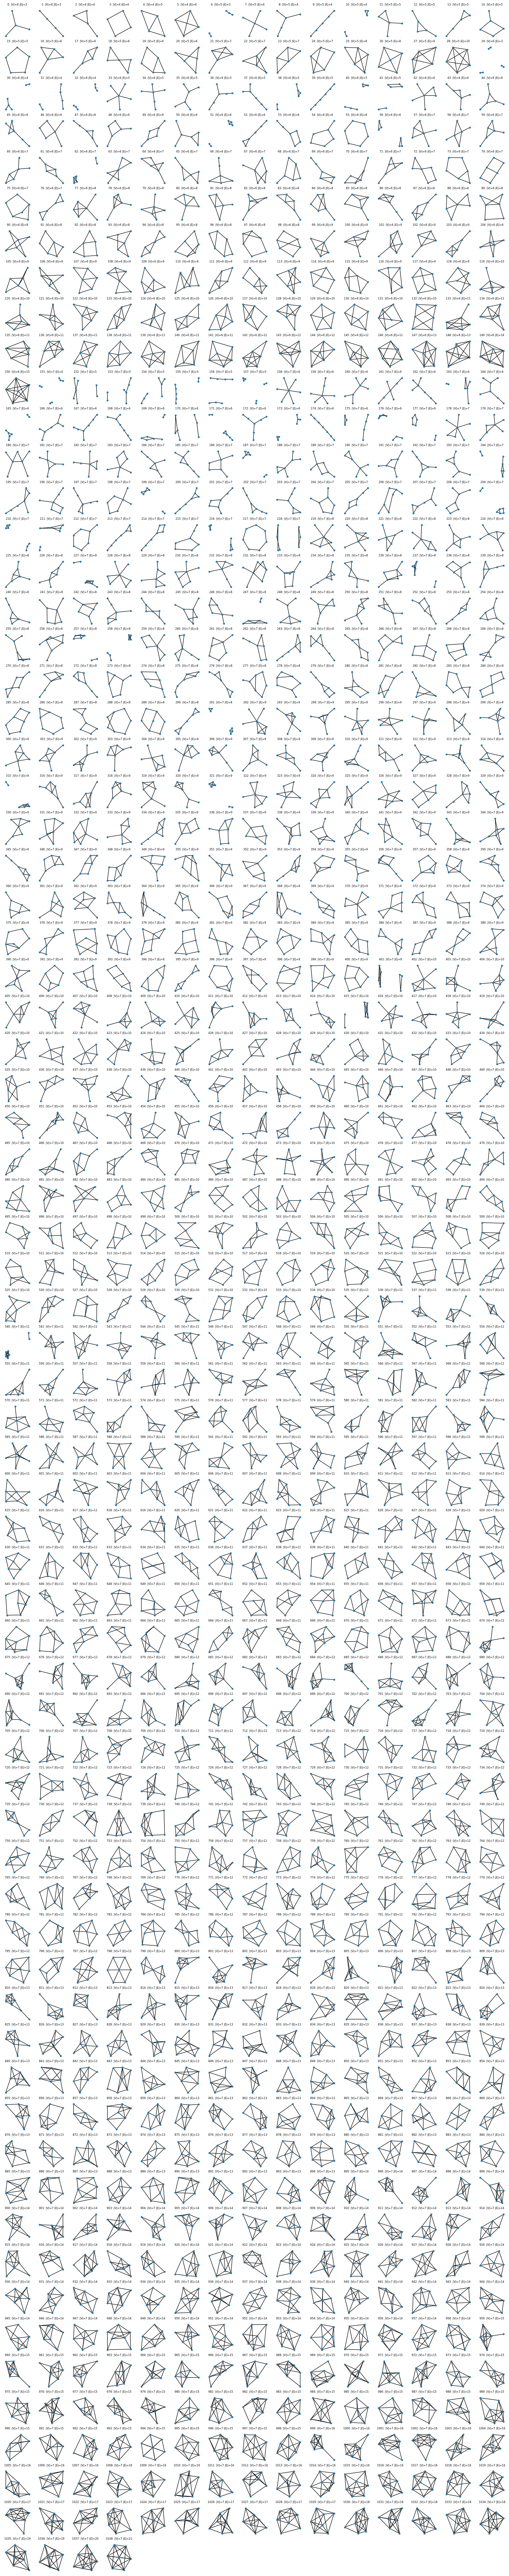

In [51]:
%%time
draw_from_atlas()

These graphs are composed of no more than 7 vertices, we insist on having a non-trivial edge set, and we restrict connected components to carry at least two vertices.
In this situation, most of these graphs look very similar from the structural perspective we have taken.
Each graph admits at most 7 distinct probes: let's make them long enough to ensure that each can cover all of a unique connected component.
Before we compute vectors, let's look at how many distinct probes characterize our 1000ish graphs:

In [163]:
distr, probes = graphs_as_distributions_probes(atlas)
len(probes)

164

So the "vocabulary" that describes each graph is composed of less than 20% the number of graphs themselves.
I believe the situation would be quite different from the large graph embedding being considered as target application for this approach.
The number of edges in such cases would be such that it would be very unlikely to hop over all of them, unless one would afford a large number of long probes.

Let's embed:

In [161]:
%%time
emb = graphs2vecs(atlas, n_components=128, tqdm=tqdm)
emb.shape

03:06:27 | INFO     |     graphs2vecs | Probe the graphs


Graph probing:   0%|          | 0/1039 [00:00<?, ?it/s]

03:06:27 | INFO     |     graphs2vecs | Calculate Wasserstein vectorization


CPU times: user 39.7 s, sys: 7.32 s, total: 47 s
Wall time: 6.15 s


(1039, 52)

CPU times: user 5.48 s, sys: 1.3 s, total: 6.78 s
Wall time: 1.67 s


<AxesSubplot: >

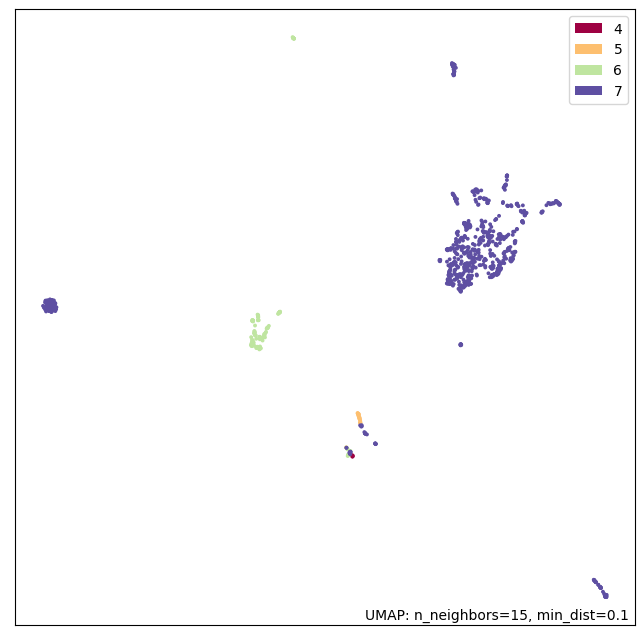

In [162]:
%%time
u = UMAP()
u.fit_transform(emb)
num_vertices = np.array([nx.number_of_nodes(g) for g in atlas])
up.points(u, labels=num_vertices)

The embedding structure largely reflects the number of vertices, with smaller graphs congregating together, and 7-vertex graphs showing multiple modes of similarity.
To investigate further, one is welcome to use an interactive plot (no, it's not [This Not That](https://github.com/TutteInstitute/thisnotthat/)),
and to use the `draw_from_atlas` function to puzzle visually why graphs are considered similar.

In [160]:
show(
    up.interactive(
        u,
        labels=num_vertices,
        hover_data=pd.DataFrame([
            {"i": i, "|V|": nx.number_of_nodes(g), "|E|": nx.number_of_edges(g)}
            for i, g in enumerate(atlas)
        ])
    )
)

Why are these guys bunched up?

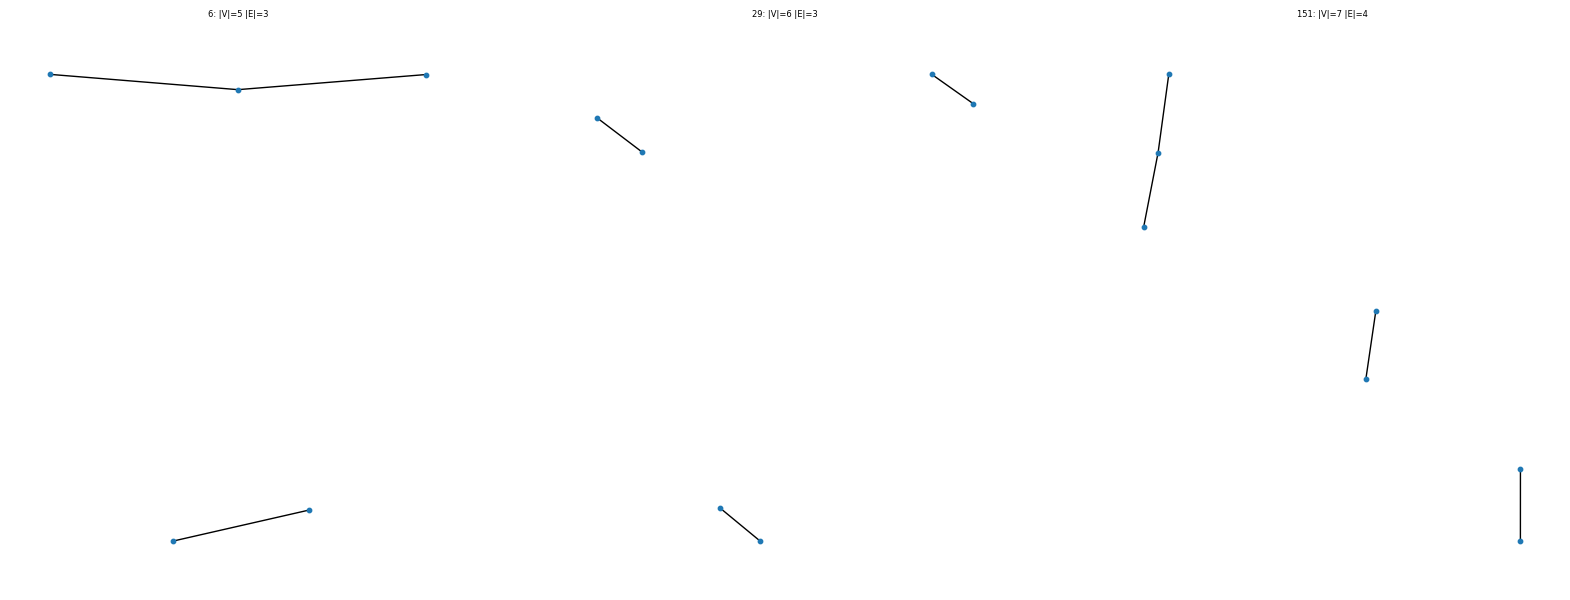

In [169]:
draw_from_atlas(6, 29, 151)

Oooh monomorphisms across disconnected components!

Why these similar?

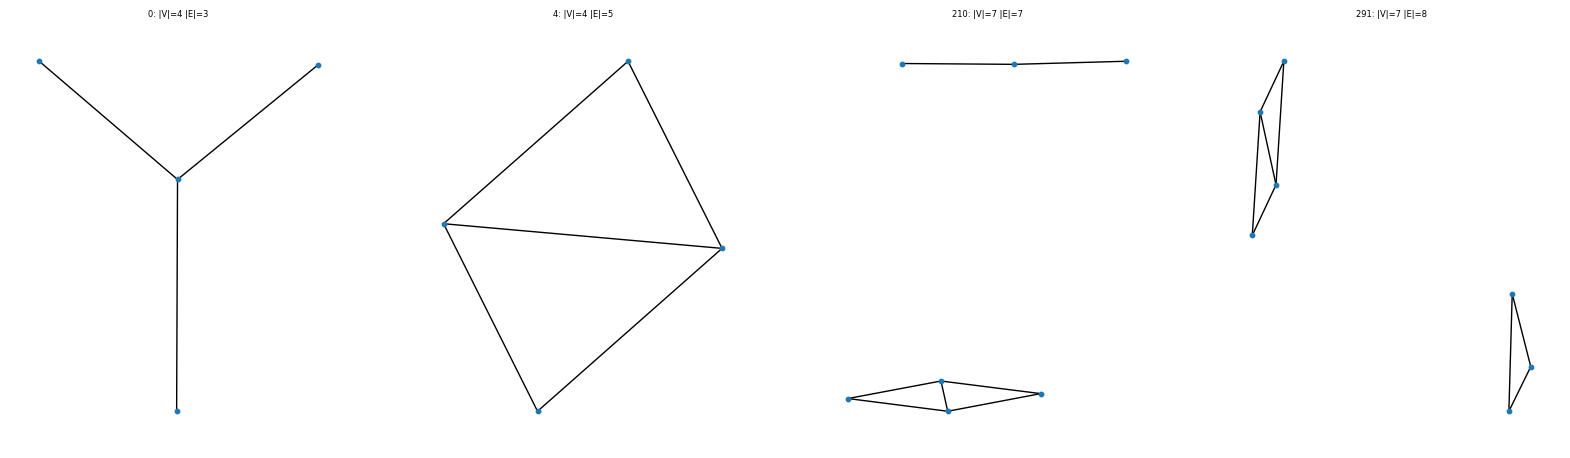

In [168]:
draw_from_atlas(0, 4, 210, 291)

Ah, good old fork, it's everywhere... but it will not share probes unless it's disconnected!

Why two very distant clumps of 6-vertex graphs?

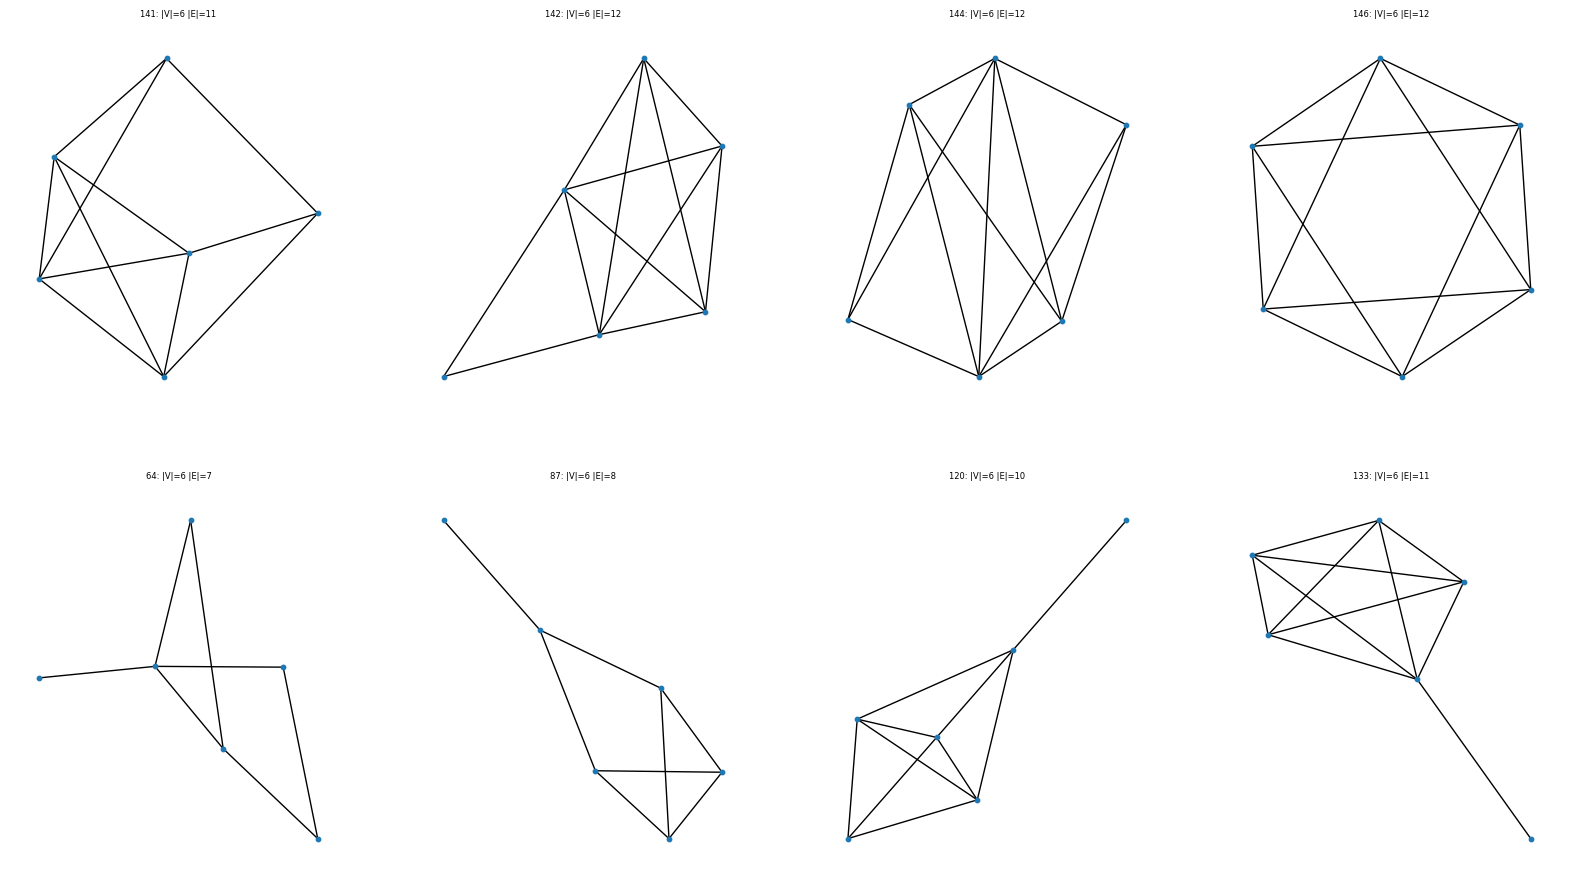

In [170]:
draw_from_atlas(141, 142, 144, 146, 64, 87, 120, 133, num_cols=4)

Less clear: the graphs on the lower row are less connected, but 133 looks a lot like 142.
More to dig out from analyzing the list of probes: it seems that adding one more edge at this scale changes the walk significantly.

Finally, a comparison of samples from two very distant cluster of 7-vertex graphs:

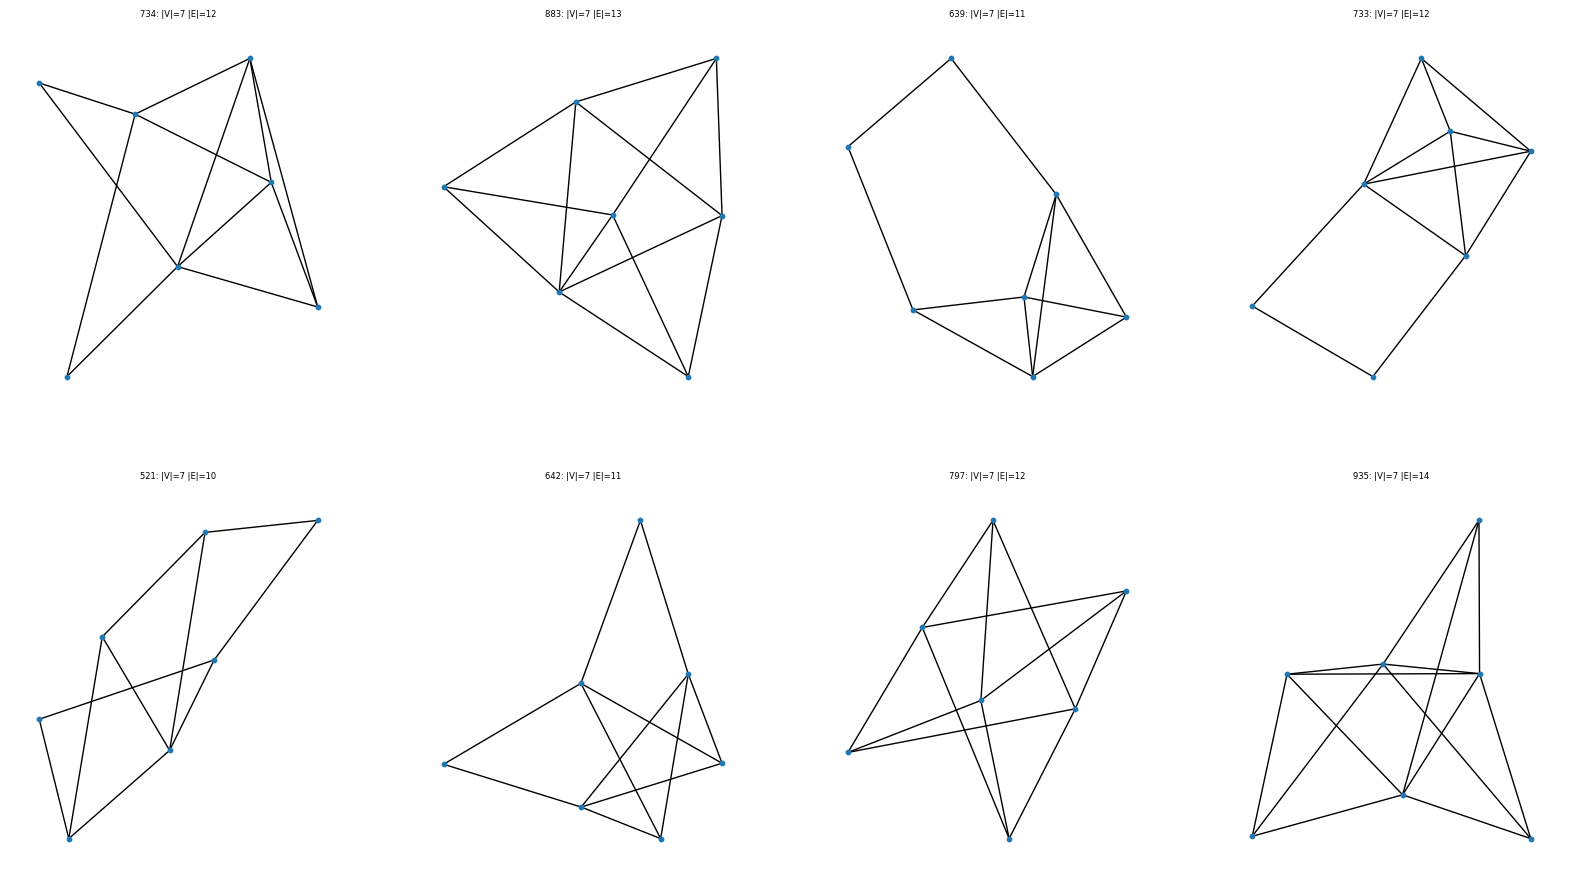

In [171]:
draw_from_atlas(734, 883, 639, 733, 521, 642, 797, 935, num_cols=4)

The lower row does present some more connectivity, but it's long past my bedtime and I can't get myself to unpack what's going on with much more seriousness.

# Next steps

Things seem to work for small graphs, and the outlook for larger graphs seems good to me.

Issues:

- The Levenshtein distance is expensive...
    Is there a way to approximate it, or to take advantage of the very particular shape of the probes?
    They are integer sequences that increase or decrease by one at every step.
- The nominal Wasserstein vectorizer is slow, and we have two alternatives we could bring into play to deal with larger distributions and larger sets of graphs to co-embed. Let's try to substitute them in place over the `WassersteinVectorizer` class.
- Paul has raised that the probe length one should choose could probably be obtained by solving some form of a Coupon Collector problem.
- Can the number of probes to compose into a distribution be chosen in this way, alternatively?
- Compare further against other graph embedding techniques: [ReFEx](https://github.com/benedekrozemberczki/RolX) ([paper](https://dl.acm.org/doi/10.1145/2020408.2020512)), graph neural nets